## Helper stuff

In [ ]:
import itertools
import matplotlib.pyplot as plt
import multiprocessing
import networkx as nx
import numpy as np
import pandas as pd
import seaborn as sns
import logging

from dataclasses import dataclass
from scipy import stats
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from typing import *

In [ ]:
logger = logging.getLogger(__name__)
FORMAT = "%(asctime)s :: [%(levelname)-8s] :: %(message)s"
logging.basicConfig(format=FORMAT)
logger.setLevel(logging.INFO)

In [ ]:
N = 5_000
DEPENDENT_VARIABLES: Final[List[str]] = [f'node-{x}' for x in range(N)][:50]
CONTROL: Final[str] = 'control'
SEED: int = 2025
DATA_FILE: Final[str] = 'data/drug-power-law-phase-transition-max-drug-strength/derived/states-1752795739394.csv'
TRAIN_SIZES = [10]
TEST_SIZES = TRAIN_SIZES
NUM_PREDICTIONS = 100

In [ ]:
states_df = pd.read_csv(DATA_FILE)#, index_col=0)


In [ ]:
states_df = states_df.reset_index()

In [ ]:
states_df#.reset_index()

,drug_name,original_network_idx,initial_condition_idx,node-0,node-1,node-2,node-3,node-4,node-5,node-6,...,node-4990,node-4991,node-4992,node-4993,node-4994,node-4995,node-4996,node-4997,node-4998,node-4999
0,control,0,0,False,True,True,True,True,False,False,...,False,True,True,True,False,True,True,True,False,True
1,control,0,0,False,True,True,True,True,False,False,...,False,True,True,True,False,True,True,True,False,True
2,control,0,0,False,True,True,True,True,False,True,...,False,True,True,True,False,True,True,True,False,True
3,control,0,0,False,True,True,True,True,False,False,...,False,True,True,True,False,True,True,True,False,True
4,control,0,0,False,True,True,True,True,False,False,...,False,True,True,True,False,True,True,True,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54995,drug-10,49,9,False,True,False,True,False,True,True,...,False,True,False,True,True,False,False,False,True,False
54996,drug-10,49,9,False,True,False,True,False,True,True,...,False,True,False,True,True,False,False,False,True,False
54997,drug-10,49,9,False,True,False,True,False,True,True,...,False,True,False,True,True,False,False,False,True,False
54998,drug-10,49,9,False,True,False,True,False,True,True,...,False,True,False,True,True,False,False,False,True,False


In [ ]:
# (original_network_idx, initial_condition_idx, time) -> [5k floats]
controls = {}
for idx, row in states_df.sort_values(by='drug_name', kind='stable').iterrows():
  controls[(row.original_network_idx, row.initial_condition_idx, idx % 10)] = np.array([
    row[f'node-{node_idx}']
    for node_idx in range(N)
  ], dtype=np.float64)
  if row.drug_name != 'control': break

In [ ]:
distances = {}
for idx, row in states_df.iterrows():
  if row.drug_name == 'control': continue
  key = (row.original_network_idx, row.initial_condition_idx, idx % 10)
  states = np.array([
    row[f'node-{node_idx}']
    for node_idx in range(N)
  ], dtype=np.float64)
  distances[key] = controls[key] - states

In [ ]:
A = np.zeros((50, 10, 10, 5000), dtype=np.float64)
for (a, b, c), item in distances.items():
  A[a, b, c, :] = np.abs(item)
#distances
#A

In [ ]:
B = A.mean(axis=2).mean(axis=1)
B.sum(axis=1)

array([ 318.24, 1194.52,   20.7 ,  118.3 ,  558.62,   47.4 ,  852.52,
        682.64,  514.88,  198.84,  652.87, 1955.73,  237.46, 1113.92,
        602.85,  677.83,  312.98,   44.1 ,   67.6 ,   28.2 ,  351.98,
         27.9 ,  181.45,  274.2 ,  212.8 ,  267.14,  707.09,   93.1 ,
         36.38,  817.12,   71.9 ,  209.3 ,  761.62,   92.03,  248.1 ,
        805.47,   49.9 ,  430.15,  666.48,  226.98,  931.85,  292.2 ,
         77.6 ,   51.4 ,  172.5 ,  850.44,  760.55,  205.4 ,  255.8 ,
         88.5 ])

In [ ]:
np.where(A[0][0][0] > 0)

(array([  17,   21,   26,   31,   32,   34,   48,   52,   62,   77,   80,
          87,   94,   99,  113,  116,  119,  121,  122,  134,  153,  170,
         175,  176,  180,  181,  186,  188,  190,  204,  205,  207,  211,
         212,  238,  239,  244,  249,  257,  281,  286,  287,  292,  312,
         323,  325,  337,  345,  355,  357,  371,  373,  385,  392,  396,
         414,  425,  427,  439,  441,  442,  449,  451,  458,  462,  480,
         511,  515,  535,  538,  539,  571,  573,  610,  614,  616,  655,
         663,  679,  719,  736,  739,  762,  766,  780,  796,  811,  826,
         835,  838,  845,  871,  895,  896,  903,  917,  943,  950,  958,
         963,  968,  970,  971,  975,  976,  977,  982,  989,  997, 1003,
        1015, 1022, 1023, 1024, 1037, 1051, 1054, 1065, 1066, 1076, 1083,
        1090, 1112, 1126, 1130, 1148, 1178, 1186, 1200, 1206, 1225, 1228,
        1230, 1232, 1234, 1238, 1252, 1258, 1281, 1283, 1296, 1307, 1311,
        1326, 1333, 1345, 1350, 1351, 

In [ ]:
k=10
np.argsort(B[0], stable=True)[-k:]

array([2794, 3146, 3373, 3533, 3716, 3758, 3930, 4175, 4202, 4902])

<Axes: >

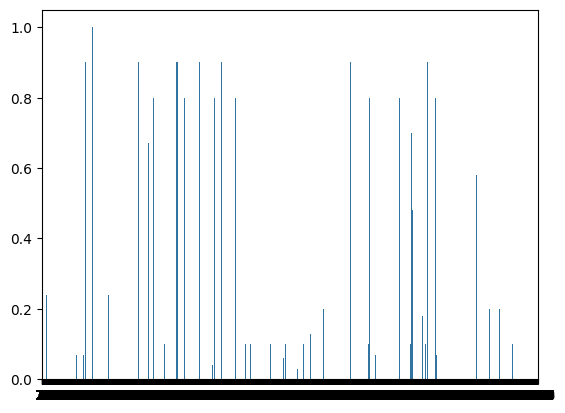

In [ ]:
sns.barplot(B[0])

In [ ]:
from itertools import chain

In [ ]:
# in_dists = []
# out_dists = []
data = []
fine_grained_selected_data = []
for max_num_features in 2 ** np.arange(0, 8):
  for original_network_idx in range(50):
    nodes_strs = list(eval(feature_df[(feature_df.original_network_idx == original_network_idx) & (feature_df.max_num_features==max_num_features)].features.iloc[0]))
    node_idxs = [int(node_str.split('-')[1]) for node_str in nodes_strs]
    # print(node_idxs)
    # in_dists.append(B[original_network_idx][node_idxs])
    # out_dists.append(np.delete(B[original_network_idx], node_idx))
    data.append({
      'type': 'selected',
      'original_network_idx': original_network_idx,
      'node_idxs': node_idxs,
      'max_num_features': max_num_features,
      'dist': B[original_network_idx][node_idxs].mean(),
    })
    data.append({
      'type': 'not-selected',
      'original_network_idx': original_network_idx,
      'node_idxs': node_idxs,
      'max_num_features': max_num_features,
      'dist': np.delete(B[original_network_idx], node_idxs).mean(),
    })
    for node_idx in node_idxs:
      fine_grained_selected_data.append({
        'original_network_idx': original_network_idx,
        'node_idx': node_idx,
        'max_num_features': max_num_features,
        'dist': B[original_network_idx][node_idx].squeeze(),
        'above-cutoff?': B[original_network_idx][node_idx].squeeze() > 0.0815,
      })



selected_df = pd.DataFrame(data)
fine_grained_selected_df = pd.DataFrame(fine_grained_selected_data)
#d_in = np.array(list(chain.from_iterable(in_dists)))
#d_out = np.array(list(chain.from_iterable(out_dists)))

In [ ]:
fine_grained_selected_df[fine_grained_selected_df.max_num_features == 16].mean()

original_network_idx      24.527344
node_idx                2473.795573
max_num_features          16.000000
dist                       0.140404
dtype: float64

In [ ]:
max_num_features = 16
# TOP = 32
dts = []
nds = []
for original_network_idx in range(50):
  nodes_strs = list(eval(feature_df[(feature_df.original_network_idx == original_network_idx) & (feature_df.max_num_features==max_num_features)].features.iloc[0]))
  node_idxs = [int(node_str.split('-')[1]) for node_str in nodes_strs]
  x = np.zeros((max_num_features,))
  dat = B[original_network_idx][node_idxs]
  x[:len(dat)] = dat
  nds.append(node_idxs)
  # dat = np.delete(B[original_network_idx], node_idxs)
  #print(len(dat))
  # st = sorted(dat, reverse=True)#sorted(dat, reverse=True)
  # x[:] = st[:TOP]
  dts.append(x)

dts_np = np.array(dts)

In [ ]:
# [dt[~(max_num_features-19)] for dt in dts]
#print(dts[0])#, nds[0])

np.argsort(dts_np[0], stable=True)[::-1]#, axis=1)

rows, cols = np.where(dts_np <= .08)

print(rows)
print(cols)
print(nds)

#print(rows, cols)

important_nodes = []

for row, col in zip(rows, cols):
  if col < len(nds[row]):
    important_nodes.append((int(row.squeeze()), f'node-{nds[row][col]}'))

[ 0  0  0  0  0  0  0  0  0  0  0  0  1  1  1  1  1  2  2  2  2  2  2  2
  2  2  2  2  2  2  2  2  2  3  3  3  3  3  3  3  3  3  3  3  3  3  4  4
  4  4  4  4  4  4  4  4  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  6
  6  6  6  6  6  6  6  7  7  7  7  7  7  8  8  8  8  8  8  8  8  8  8  9
  9  9  9  9  9  9  9  9  9  9 10 10 10 10 10 10 10 10 10 10 11 11 11 11
 11 11 11 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 13 13 13 13 14 14
 14 14 14 14 14 14 14 14 14 14 14 14 15 15 15 15 15 15 15 15 16 16 16 16
 16 16 16 16 16 16 16 16 16 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17
 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 19 19 19 19 19 19 19 19 19
 19 19 19 19 19 19 19 20 20 20 20 20 20 20 20 21 21 21 21 21 21 21 21 21
 21 21 21 21 21 21 21 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 23 23
 23 23 23 23 23 23 23 23 23 23 23 24 24 24 24 24 24 24 24 24 24 24 24 24
 25 25 25 25 25 25 25 25 25 25 25 25 25 26 26 26 26 27 27 27 27 27 27 27
 27 27 27 28 28 28 28 28 28 28 28 28 28 28 28 28 28

In [ ]:
Gf_data = []
# betweenness_centralities = [nx.betweenness_centrality(G) for G in Gs]
# closeness_centralities = [nx.closeness_centrality(G) for G in Gs]
for original_network_idx, node in important_nodes:
  G = Gs[original_network_idx]
  Gf_data.append({
    'original_node_idx': original_network_idx,
    'node': node,
    'in_degree': G.in_degree(node),
    'out_degree': G.out_degree(node),
    'pred_max_out_degree': max((G.out_degree(pred) for pred in G.predecessors(node)), default=None),
    'pred_max_in_degree': max((G.in_degree(pred) for pred in G.predecessors(node)), default=None),
    # 'betweenness-centrality': betweenness_centralities[original_network_idx][node],
    # 'closeness-centrality': closeness_centrality[original_network_idx][node],
  })

Gf_df = pd.DataFrame(Gf_data)

In [ ]:
G_df['in_degree'].mean(), G_df['out_degree'].mean(), G_df['pred_max_in_degree'].mean(), G_df['pred_max_out_degree'].mean()

(np.float64(6.426008968609866),
 np.float64(3.2556053811659194),
 np.float64(8.847533632286995),
 np.float64(2323.134529147982))

In [ ]:
Gf_df['in_degree'].mean(), Gf_df['out_degree'].mean(), Gf_df['pred_max_in_degree'].mean(), Gf_df['pred_max_out_degree'].mean()

(np.float64(5.495412844036697),
 np.float64(3.15045871559633),
 np.float64(8.088560885608857),
 np.float64(1993.0258302583027))

In [ ]:
degree_data_df['in-degree'].mean(), degree_data_df['out-degree'].mean(), degree_data_df['pred_max_in_degree'].mean(), degree_data_df['pred_max_out_degree'].mean()

(np.float64(5.665156),
 np.float64(5.665156),
 np.float64(8.325446566586502),
 np.float64(2052.029341502487))

In [ ]:
def rpow_trunc(gamma, n, kmin=1, kmax=1000):
  ks = np.arange(kmin, kmax + 1)
  w = ks ** (-gamma)
  p = w / w.sum()
  return np.random.choice(ks, size=n, p=p)

# x = rpow_trunc(alpha=2.2, n=100_000, kmin=1, kmax=500)

In [ ]:
G = nx.DiGraph()
n = 5000
# k = 8
gamma = 2.1
G.add_nodes_from(range(n))

out_degrees = rpow_trunc(gamma, n, kmin=1, kmax=n)   # np.random.poisson(lam=k, size=(n,))
for i in range(n):
  connections = np.random.choice(range(n), size=(out_degrees[i],), replace=False)
  for j in connections:
    G.add_edge(i, j)

In [ ]:
zeta = lambda a: sum(k**(-a) for k in range(1, n+1)) # gamma-1
zeta(gamma-1)/zeta(gamma)

4.049436794987137

In [ ]:
G_df = pd.DataFrame(
  data=[
    (node, G.in_degree(node), G.out_degree(node))
    for node in G.nodes()
  ],
  columns=['node', 'in_degree', 'out_degree'],
)

[Text(0.5, 0, 'In degree')]

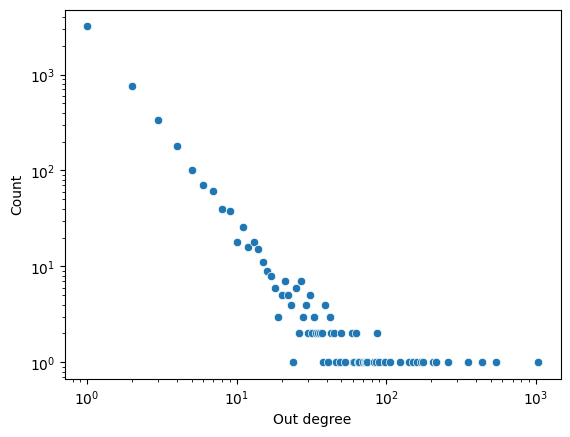

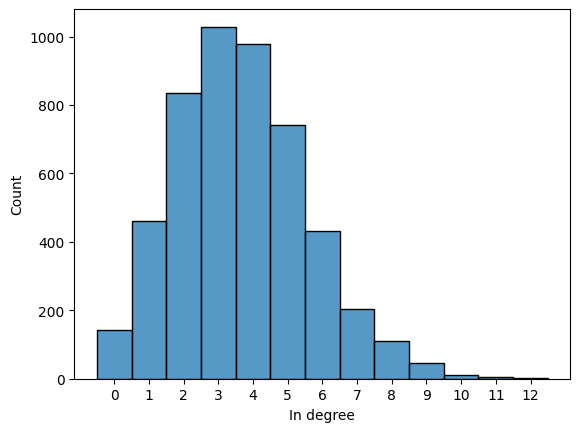

In [ ]:
# g = sns.histplot(
#   G_df,
#   x='out_degree',
#   # discrete=True,
# )

xticks = np.arange(G_df['out_degree'].min(), G_df['out_degree'].max()+1)
# g.set_xticks(xticks)
# g.set_xticklabels([xticks[0]] + ((len(xticks) - 2) * ['']) + [xticks[-1]])

vc = G_df["out_degree"].value_counts().sort_index()
deg_df = vc.rename_axis("out_degree").reset_index(name="count")
g = sns.scatterplot(data=deg_df, x="out_degree", y="count")
g.set(xlabel='Out degree', ylabel='Count', xscale='log', yscale='log')

plt.figure()
h = sns.histplot(
  G_df,
  x='in_degree',
  discrete=True,
)

h.set_xticks(np.arange(G_df['in_degree'].min(), G_df['in_degree'].max()+1))
h.set(xlabel='In degree')

[(0.0, 20.0)]

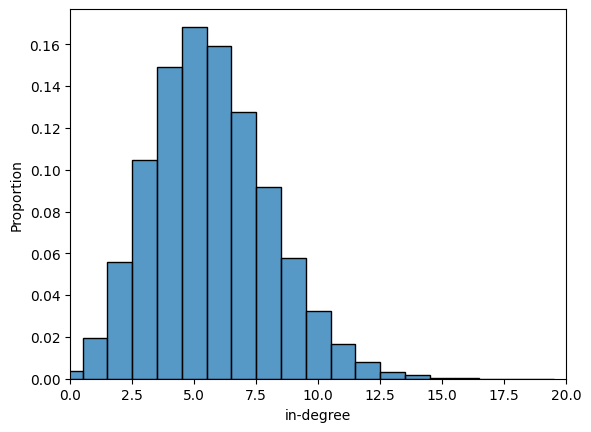

In [ ]:
,sns.histplot(degree_data_df, x='in-degree', discrete=True, stat='proportion').set(xlim=(0, 20))
#

In [ ]:
data = [
    (original_network_idx, i, x[i])
    for i in range(TOP)#range(max_num_features)
    for original_network_idx, x in enumerate(dts)
]
pdf = pd.DataFrame(data, columns=['original_network_idx', 'max_num_features', 'dist'])

[None]

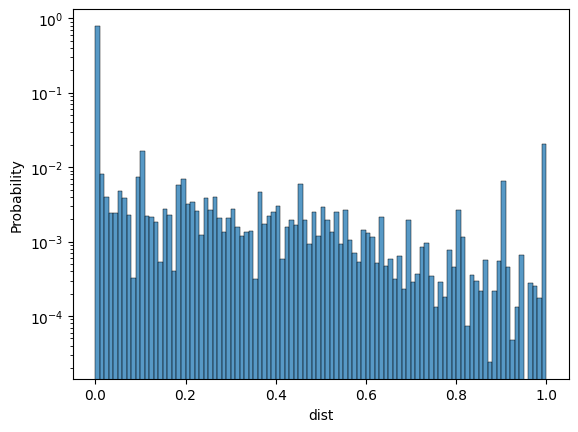

In [ ]:
sns.histplot(pdf, x='dist', bins=100, stat='probability').set(yscale='log')

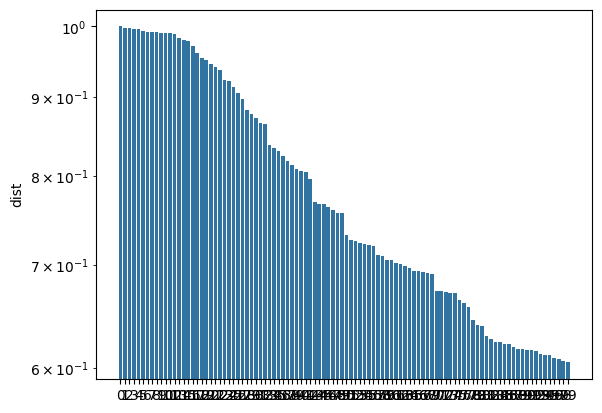

In [ ]:
sns.barplot(data=pdf, x='max_num_features', y='dist', errorbar=None).set(xlabel='', yscale='log')
plt.hlines(.08, 0, max_num_features, colors='black', linestyles='--')#, hue='original_network_idx').set(

In [ ]:
pdf

,original_network_idx,max_num_features,dist
0,0,0,0.83
1,1,0,1.00
2,2,0,1.00
3,3,0,0.80
4,4,0,0.57
...,...,...,...
1595,45,31,0.00
1596,46,31,0.00
1597,47,31,0.00
1598,48,31,0.00


In [ ]:
d_in.mean(), d_out.mean()

(np.float64(0.14040364583333334), np.float64(0.08168201640328064))

[Text(0.5, 0, 'Number of features selected'),
 Text(0, 0.5, 'Average Hamming distance from control')]

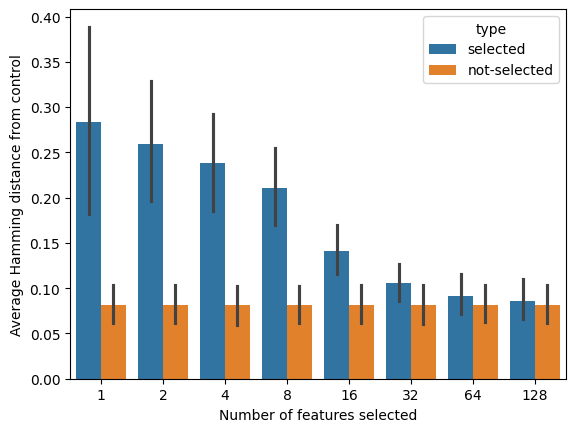

In [ ]:
sns.barplot(
  data=selected_df,
  x='max_num_features',
  y='dist',
  hue='type',
).set(
  xlabel='Number of features selected',
  ylabel='Average Hamming distance from control',
)

In [ ]:
fine_grained_selected_df

,original_network_idx,node_idx,max_num_features,dist,above-cutoff?
0,0,821,1,0.00,False
1,1,2994,1,1.00,True
2,2,2901,1,0.00,False
3,3,1147,1,0.00,False
4,4,4264,1,0.36,True
...,...,...,...,...,...
12157,49,3513,128,0.00,False
12158,49,2632,128,0.00,False
12159,49,977,128,0.00,False
12160,49,671,128,0.00,False


In [ ]:
randomly_selected_data = []
for max_num_features in 2 ** np.arange(0, 8):
  for original_network_idx in range(50):
    for initial_condition_idx in range(1):
      node_idxs = np.random.choice(N, size=max_num_features, replace=False)
      for node in node_idxs:
        randomly_selected_data.append({
          'original_network_idx': original_network_idx,
          'max_num_features': max_num_features,
          # 'initial_condition_idx': initial_condition_idx,
          'node_idx': node_idx,
          'dist': B[original_network_idx][node_idx].squeeze(),
          'above-cutoff?': B[original_network_idx][node_idx].squeeze() > 0.0815,
        })

randomly_selected_df = pd.DataFrame(randomly_selected_data)

In [ ]:
randomly_selected_df

,original_network_idx,max_num_features,node_idx,dist,above-cutoff?
0,0,1,1465,0.0,False
1,0,2,1465,0.0,False
2,0,2,1465,0.0,False
3,0,4,1465,0.0,False
4,0,4,1465,0.0,False
...,...,...,...,...,...
12745,49,128,1465,0.1,True
12746,49,128,1465,0.1,True
12747,49,128,1465,0.1,True
12748,49,128,1465,0.1,True


In [ ]:
combined_selected_df = pd.concat([
  randomly_selected_df.assign(selection_method='random'),
  fine_grained_selected_df.assign(selection_method='genetic'),
])

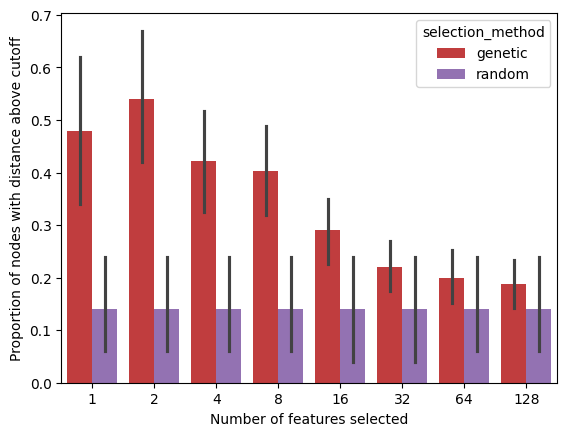

In [ ]:
palette = sns.color_palette('tab10', n_colors=5)
ax = sns.barplot(
  data=combined_selected_df.groupby(['selection_method', 'max_num_features', 'original_network_idx'])['above-cutoff?'].mean().reset_index(),
  x='max_num_features',
  y='above-cutoff?',
  hue='selection_method',
  # hue='above-cutoff?',
  palette=[palette[3], palette[4]],
  # hue_order=[True, False],
)

ax.set(
  xlabel='Number of features selected',
  ylabel='Proportion of nodes with distance above cutoff',
  # yscale='log',
)

# for container in ax.containers:
#   ax.bar_label(container)

# ax.hlines(.08, -0.5, 7.5, colors='black', linestyles='--', label='cutoff')

# hatches = ["\\\\", "."]
# # Loop over the bars
# for bars, hatch in zip(ax.containers, hatches):
#   for bar in bars:
#     bar.set_hatch(hatch)
# # create the legend again to show the new hatching
# ax.legend(title='Above cutoff?')
plt.show()

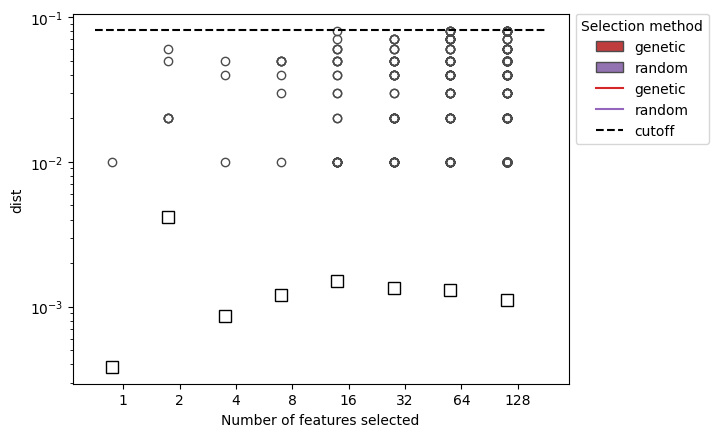

In [ ]:
palette = sns.color_palette('tab10', n_colors=5)
filter = ~combined_selected_df['above-cutoff?']
ax = sns.boxplot(
  data=combined_selected_df[filter],#.groupby(['selection_method', 'max_num_features', 'original_network_idx'])['dist'].mean().reset_index(),
  x='max_num_features',
  y='dist',
  hue='selection_method',
  # hue='above-cutoff?',
  palette=[palette[3], palette[4]],
  hue_order=['genetic', 'random'],
  legend=True,
  #split=True,
  showmeans=True,
  # meanline=True,
  meanprops={'marker':'s','markerfacecolor':'white','markeredgecolor':'black','markersize':'8'},
)

ax.set(
  xlabel='Number of features selected',
  #ylabel='Proportion of nodes with distance above cutoff',
  yscale='log',
)

sns.lineplot(
  data=combined_selected_df[filter],
  x=np.log2(combined_selected_df[filter]['max_num_features'])-.25,
  y='dist',
  hue='selection_method',
  ax=ax,
  palette=[palette[3], palette[4]],
  hue_order=['genetic', 'random'],
)

ax.hlines(.0815, -0.5, 7.5, colors='black', linestyles='--', label='cutoff')

ax.legend(title='Selection method', loc='lower right')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1+.02))

In [ ]:
# fine_grained_selected_df.groupby(['max_num_features', 'original_network_idx'])['above-cutoff?'].mean().reset_index()
combined_selected_df[combined_selected_df['above-cutoff?']]#.groupby(['selection_method', 'max_num_features', 'original_network_idx'])['dist'].mean().reset_index()

,original_network_idx,max_num_features,node_idx,dist,above-cutoff?,selection_method
2805,11,1,1465,0.9,True,random
2806,11,2,1465,0.9,True,random
2807,11,2,1465,0.9,True,random
2808,11,4,1465,0.9,True,random
2809,11,4,1465,0.9,True,random
...,...,...,...,...,...,...
12111,49,128,4051,0.1,True,genetic
12116,49,128,1084,0.1,True,genetic
12123,49,128,3547,0.1,True,genetic
12142,49,128,4223,0.1,True,genetic


In [ ]:
fine_grained_selected_df.groupby('max_num_features').agg(lambda x: print(x) or x['above-cutoff?'].value_counts(normalize=True)[True])

0      0
1      1
2      2
3      3
4      4
5      5
6      6
7      7
8      8
9      9
10    10
11    11
12    12
13    13
14    14
15    15
16    16
17    17
18    18
19    19
20    20
21    21
22    22
23    23
24    24
25    25
26    26
27    27
28    28
29    29
30    30
31    31
32    32
33    33
34    34
35    35
36    36
37    37
38    38
39    39
40    40
41    41
42    42
43    43
44    44
45    45
46    46
47    47
48    48
49    49
Name: original_network_idx, dtype: int64
0      0
1      1
2      2
3      3
4      4
5      5
6      6
7      7
8      8
9      9
10    10
11    11
12    12
13    13
14    14
15    15
16    16
17    17
18    18
19    19
20    20
21    21
22    22
23    23
24    24
25    25
26    26
27    27
28    28
29    29
30    30
31    31
32    32
33    33
34    34
35    35
36    36
37    37
38    38
39    39
40    40
41    41
42    42
43    43
44    44
45    45
46    46
47    47
48    48
49    49
Name: 1, dtype: int64


KeyError: 'above-cutoff?'

In [ ]:
selected_df[(selected_df['max_num_features'] == 16) & (selected_df['type'] == 'not-selected')]['dist'].mean()

np.float64(0.08150269294944908)

In [ ]:
def predict_dist(X: pd.DataFrame, *, clf: RandomForestClassifier) -> pd.Series:
  y = clf.predict(X)
  # Plurality vote.
  values, counts = np.unique(y, return_counts=True)
  max_index = np.argmax(counts)
  drug_prediction = values[max_index]
  return drug_prediction


def predict(
  clf: RandomForestClassifier,
  *,
  X_test: pd.DataFrame,
  y_test: np.ndarray,
  drug_actual: str,
  test_size: int,
  n_predictions: int,
):
  predicted, actuals = [], []
  for _ in range(n_predictions):
    X_int = X_test[y_test == drug_actual]
    if len(X_int) < test_size: break
    X = X_int.sample(test_size)
    drug_prediction = predict_dist(X, clf=clf)
    predicted.append(drug_prediction)
    actuals.append(drug_actual)
  return predicted, actuals

In [ ]:
def get_performance_data(df: pd.DataFrame, trial: int, train_size: int, test_size: int, *, dep_vars: Optional[List[str]]):
  logger.info(f'START {trial=} {train_size=} {test_size=}')
  performance_data = []
  dependent_variables = dep_vars if dep_vars is not None else DEPENDENT_VARIABLES
  df_train = (
    df.groupby('Drug', group_keys=False)
      .apply(lambda x: x.sample(n=train_size) if len(x) >= train_size else pd.Series(dtype=np.float64))
  )
  df_test = df.drop(df_train.index)
  X_train, y_train = df_train[dependent_variables], df_train['Drug']

  clf = RandomForestClassifier(n_estimators=100)
  clf.fit(X_train, y_train)

  X_test, y_test = df_test[dependent_variables], df_test['Drug']
  drugs: List[str] = sorted(list((df_train['Drug'].unique())))
  performance_data = []
  for drug_actual in drugs:
    predictions, actuals = predict(
      clf,
      X_test=X_test,
      y_test=y_test,
      drug_actual=drug_actual,
      test_size=test_size,
      n_predictions=NUM_PREDICTIONS,
    )
    performance_data_single = [
      {
        'trial': trial,
        'test_size': test_size,
        'train_size': train_size,
        'drug_prediction': drug_prediction,
        'drug_actual': drug_actual,
        'correct': bool(drug_actual == drug_prediction)
      }
      for drug_prediction, drug_actual in zip(predictions, actuals)
    ]
    performance_data.extend(performance_data_single)
    accuracy = sum(
      result['correct']
      for result in performance_data_single
    ) / len(predictions) if predictions else None
    if accuracy is not None:
      logger.info(f'DONE {trial=} {train_size=} {test_size=} {drug_actual=} accuracy={accuracy * 100:.2f}')
  return performance_data, clf

In [ ]:
def train_and_test(df: pd.DataFrame, *, num_trials: int, dep_vars: Optional[List[str]] = None):
  performance_data, clfs = [], []
  for data, clf in (
      get_performance_data(df, trial, train_size, test_size, dep_vars=dep_vars)
        for trial in range(num_trials)
        for train_size in TRAIN_SIZES
        for test_size in TEST_SIZES
      ):
    performance_data.extend(data)
    clfs.append(clf)
  return pd.DataFrame(performance_data), clfs

In [ ]:
def plot_confusion(performance_df: pd.DataFrame):
  DRUGS = sorted(list((performance_df['drug_actual'].unique())))
  test_sizes = performance_df['test_size'].unique()
  train_sizes = performance_df['train_size'].unique()
  fig, ax = plt.subplots(len(train_sizes), len(test_sizes), figsize=2*np.array([12, 8]))
  print(ax)
  for i, train_size in enumerate(train_sizes):
    for j, test_size in enumerate(test_sizes):
      print(i, j)
      sub_df = performance_df[(performance_df['test_size'] == test_size) & (performance_df['train_size'] == train_size)]
      predicted = sub_df['drug_prediction']
      actuals = sub_df['drug_actual']
      cm = confusion_matrix(actuals, predicted, labels=DRUGS)
      g = sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=DRUGS, yticklabels=DRUGS, ax=ax[i, j] if False else ax)
      g.set(title=f'Train Size: {train_size}, Test Size: {test_size}', xlabel='Predicted Drug', ylabel='Actual Drug')
  return fig

## Actual stuff

In [ ]:
states_df = pd.read_csv(DATA_FILE, index_col=0)
states_df = states_df.reset_index().rename(columns={"drug_name": "Drug"})

In [ ]:
states_df

,Drug,original_network_idx,initial_condition_idx,node-0,node-1,node-2,node-3,node-4,node-5,node-6,...,node-4990,node-4991,node-4992,node-4993,node-4994,node-4995,node-4996,node-4997,node-4998,node-4999
0,control,0,0,False,True,True,True,True,False,False,...,False,True,True,True,False,True,True,True,False,True
1,control,0,0,False,True,True,True,True,False,False,...,False,True,True,True,False,True,True,True,False,True
2,control,0,0,False,True,True,True,True,False,True,...,False,True,True,True,False,True,True,True,False,True
3,control,0,0,False,True,True,True,True,False,False,...,False,True,True,True,False,True,True,True,False,True
4,control,0,0,False,True,True,True,True,False,False,...,False,True,True,True,False,True,True,True,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54995,drug-10,49,9,False,True,False,True,False,True,True,...,False,True,False,True,True,False,False,False,True,False
54996,drug-10,49,9,False,True,False,True,False,True,True,...,False,True,False,True,True,False,False,False,True,False
54997,drug-10,49,9,False,True,False,True,False,True,True,...,False,True,False,True,True,False,False,False,True,False
54998,drug-10,49,9,False,True,False,True,False,True,True,...,False,True,False,True,True,False,False,False,True,False


In [ ]:
original_network_idx = 0
particular_states_df = states_df[states_df['original_network_idx'] == original_network_idx].drop(columns=['original_network_idx', "initial_condition_idx"])
particular_states_df.sample(n=10)

,Drug,node-0,node-1,node-2,node-3,node-4,node-5,node-6,node-7,node-8,...,node-4990,node-4991,node-4992,node-4993,node-4994,node-4995,node-4996,node-4997,node-4998,node-4999
973,drug-9,False,True,True,True,True,False,False,True,True,...,False,True,True,True,False,True,True,True,False,True
266,drug-2,False,True,True,True,True,False,False,True,True,...,False,True,True,True,False,True,True,True,False,True
334,drug-3,False,False,True,True,True,False,False,True,True,...,False,True,True,True,False,True,True,True,False,True
338,drug-3,False,False,True,True,True,False,False,True,True,...,False,True,True,True,False,True,True,True,False,True
819,drug-8,False,True,True,True,True,False,False,True,True,...,False,True,True,True,False,True,True,True,False,True
456,drug-4,False,True,True,True,True,False,True,True,True,...,False,True,True,True,False,True,True,True,False,True
514,drug-5,False,True,True,True,True,False,False,True,True,...,False,True,True,True,False,True,True,True,False,True
725,drug-7,False,True,True,True,True,False,True,False,True,...,False,True,True,False,False,True,True,True,False,True
333,drug-3,False,False,True,True,True,False,False,True,True,...,False,True,True,True,False,True,True,True,False,True
134,drug-1,False,True,True,True,True,False,False,False,True,...,False,True,True,True,False,True,True,True,False,True


In [ ]:
def sample_mean_cov(df: pd.DataFrame):
    """
    Returns μ (1-D array of length N) and Σ (N×N array)
    """
    X = df.values.astype(float)             # M × N
    μ = X.mean(axis=0)                      # length-N
    Xc = X - μ                              # centre
    Σ = (Xc.T @ Xc) / (X.shape[0] - 1)      # unbiased sample covariance
    return μ, Σ

def greedy_mmse_columns(Σ: np.ndarray, k: int):
    """
    Select k indices that greedily maximise Tr(Σ_{:,S} Σ_{S,S}^{-1} Σ_{S,:})
    = minimise expected linear-MMSE reconstruction error.
    O(k N²) but performs well up to ~10⁴ dimensions.
    """
    N = Σ.shape[0]
    S = []                        # selected indices
    inv_SΣS = None                # will hold Σ_{S,S}^{-1}

    for _ in range(k):
        best_gain, best_j = -np.inf, None

        # Pre-compute pieces used for every candidate
        if S:
            Σ_S = Σ[:, S]                      # N × |S|
            # Re-use current inverse to avoid full inverse each loop
            # Sherman-Morrison formula for fast rank-1 updates
        for j in range(N):
            if j in S:                         # already picked
                continue
            if not S:                          # very first variable
                gain = Σ[j, j]
            else:
                # Block-inverse trick: compute incremental gain cheaply
                Σ_jS = Σ[j, S]
                v = np.linalg.solve(inv_SΣS, Σ_jS)     # |S| ×1
                denom = Σ[j, j] - Σ_jS @ v
                gain = Σ[j, j] - denom
            if gain > best_gain:
                best_gain, best_j = gain, j

        # Update the inverse Σ_{S,S}^{-1} efficiently
        if S:
            Σ_jS = Σ[best_j, S]
            u = np.append(-np.linalg.solve(inv_SΣS, Σ_jS), 1.0)
            denom = Σ[best_j, best_j] - Σ_jS @ u[:-1]
            u = u / np.sqrt(denom)
            # Expand the inverse using the Ben-Israel formula
            inv_SΣS = np.block([
                [inv_SΣS + np.outer(u[:-1], u[:-1]),           u[:-1][:, None]],
                [u[:-1][None, :],                             np.array([[1.0]])]
            ])
        else:
            inv_SΣS = np.array([[1 / Σ[best_j, best_j]]])

        S.append(best_j)

    return S

In [ ]:
df = particular_states_df[particular_states_df['Drug'] == 'control'].drop(columns=['Drug'])#.values.astype(float).mean(axis=0)
μ, Σ = sample_mean_cov(df)
k = 17
idx = greedy_mmse_columns(Σ, k)
selected_cols = df.columns[idx]

/var/folders/nr/wh_xmblj0d57jnlt98fssqqh0000gp/T/ipykernel_43059/356482808.py:48: RuntimeWarning: divide by zero encountered in divide
  u = u / np.sqrt(denom)
/var/folders/nr/wh_xmblj0d57jnlt98fssqqh0000gp/T/ipykernel_43059/356482808.py:48: RuntimeWarning: invalid value encountered in divide
  u = u / np.sqrt(denom)


ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 70000 is different from 5000)

In [ ]:
selected_cols

Index(['node-4347', 'node-2266', 'node-206', 'node-280', 'node-535',
       'node-692', 'node-1477', 'node-2779', 'node-3015', 'node-3029',
       'node-4589', 'node-4672', 'node-176'],
      dtype='object')

In [ ]:
particular_network_df

,source,target,weight
0,721,0,-0.250532
1,1484,0,-0.808049
2,2290,0,0.002714
3,2832,0,-0.317106
4,3760,0,0.628091
...,...,...,...
19404,4929,4998,-0.263355
19405,1091,4999,0.654592
19406,1322,4999,-0.909617
19407,3218,4999,-0.975062


In [ ]:
reduced_particular_states_df = particular_states_df[['Drug'] + [f'node-{x}' for x in range(100)]]
reduced_particular_states_df.head()

,Drug,node-0,node-1,node-2,node-3,node-4,node-5,node-6,node-7,node-8,...,node-90,node-91,node-92,node-93,node-94,node-95,node-96,node-97,node-98,node-99
0,control,False,True,True,True,True,False,False,True,True,...,False,False,True,False,False,True,False,True,True,True
1,control,False,True,True,True,True,False,False,True,True,...,False,False,True,False,False,True,False,False,True,False
2,control,False,True,True,True,True,False,True,True,True,...,False,False,True,False,False,True,False,True,True,True
3,control,False,True,True,True,True,False,False,True,True,...,False,False,True,False,False,True,False,True,True,True
4,control,False,True,True,True,True,False,False,True,True,...,False,False,True,False,False,True,False,False,True,False


In [ ]:
reversed_networks_df = pd.read_csv('data/drug-power-law-phase-transition-max-drug-strength-50-reversed-edges/derived/networks-1756847167231.csv', index_col=0).reset_index()
reversed_networks_df

,original_network_idx,source,target,weight
0,0,1303,0,0.424138
1,0,2023,0,0.682896
2,0,941,1,-0.050609
3,0,1618,1,-0.266615
4,0,2456,1,0.626735
...,...,...,...,...
1416284,49,4628,4995,0.425280
1416285,49,1545,4996,-0.652860
1416286,49,3637,4997,-0.220607
1416287,49,3147,4998,-0.848183


In [ ]:
networks_df = pd.read_csv('data/drug-power-law-phase-transition-max-drug-strength/derived/networks-1752795739394.csv')#, index_col=0).reset_index()
networks_df.head()

,original_network_idx,source,target,weight
0,0,721,0,-0.250532
1,0,1484,0,-0.808049
2,0,2290,0,0.002714
3,0,2832,0,-0.317106
4,0,3760,0,0.628091


<Axes: xlabel='node', ylabel='importance'>

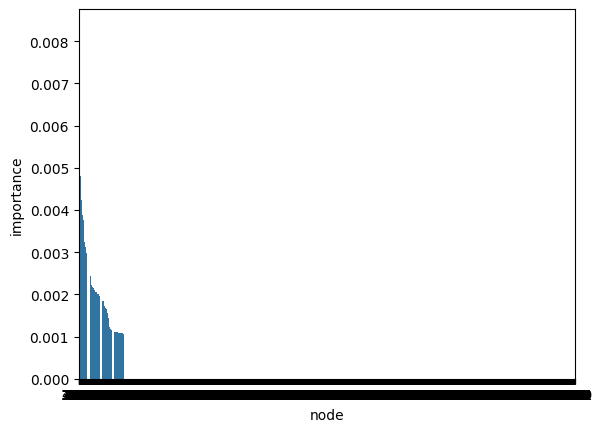

In [ ]:
k = N
importances_df = pd.DataFrame(data=list(zip(range(N), clfs[0].feature_importances_)), columns=['node', 'importance'])
sns.barplot(
  data=importances_df.sort_values(by='importance', ascending=False).reset_index().head(k),
  x='node',
  y='importance',
  order=importances_df.sort_values(by='importance', ascending=False).reset_index().head(k)['node']
)

In [ ]:
importances_df.sort_values(by='importance', ascending=False).reset_index(drop=True).head(10)

NameError: name 'importances_df' is not defined

In [ ]:
particular_network_df = networks_df[networks_df['original_network_idx'] == original_network_idx].drop(columns=['original_network_idx'])
particular_network_df.head()

,source,target,weight
1389485,1084,1,-0.193309
1389486,2652,1,0.090739
1389487,2714,1,0.293328
1389488,3836,1,0.218259
1389489,2541,2,-0.659490


In [ ]:
particular_reversed_network_df = reversed_networks_df[reversed_networks_df['original_network_idx'] == original_network_idx].drop(columns=['original_network_idx'])
particular_reversed_network_df.sort_values(by=['source', 'target']).head()

,source,target,weight
2753,0,721,-0.102667
6162,0,1484,0.795669
9081,0,2290,0.002714
10441,0,2832,-0.017460
13691,0,3760,-0.519478


In [ ]:
G = nx.DiGraph()
for _, row in particular_network_df.iterrows():
  G.add_edge(row['source'], row['target'], weight=row['weight'])

In [ ]:
degree_data_df = pd.DataFrame(
  data=[
    (node, G.in_degree(node), G.out_degree(node))
    for node in G.nodes()
  ],
  columns=['node', 'in-degree', 'out-degree'],
)
degree_data_df.head()

,node,in-degree,out-degree
0,1084.0,7,5
1,1.0,4,1
2,2652.0,5,6
3,2714.0,3,4
4,3836.0,9,111


In [ ]:
degree_data = []
for idx, G in enumerate(Gs):
  betweenness_centrality = nx.betweenness_centrality(G)
  closeness_centrality = nx.closeness_centrality(G)
  for node in G:
    degree_data.append({
      'original_network_idx': idx,
      'node': node,
      'in-degree': G.in_degree(node),
      'out-degree': G.out_degree(node),
      'pred_max_in_degree': max((G.in_degree(pred) for pred in G.predecessors(node)), default=None),
      'pred_max_out_degree': max((G.out_degree(pred) for pred in G.predecessors(node)), default=None),
      'betweenness_centrality': betweenness_centrality[node],
      'closeness_centrality': closeness_centrality[node],
    })

degree_data_df = pd.DataFrame(degree_data)

In [ ]:
degree_data_df['out-degree'].mean()

np.float64(5.665156)

In [ ]:
degree_data_df['in-degree'].mean() #* 2**7

np.float64(5.665156)

<Axes: xlabel='in-degree', ylabel='Proportion'>

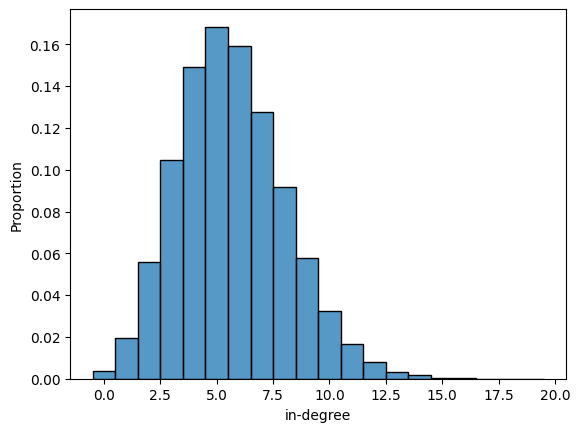

In [ ]:
sns.histplot(degree_data_df['in-degree'], discrete=True, stat='proportion')

[None]

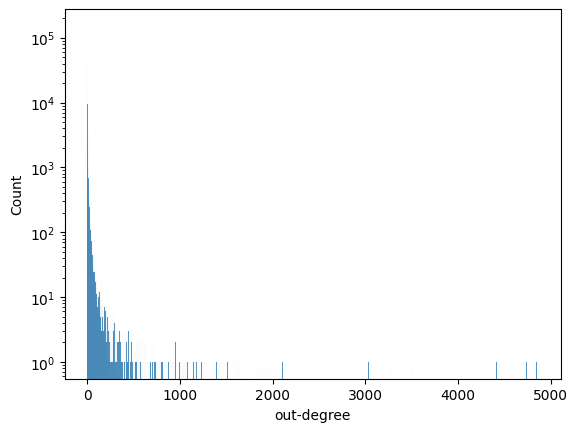

In [ ]:
sns.histplot(degree_data_df['out-degree'], discrete=True).set(yscale='log')

<Axes: xlabel='node', ylabel='in-degree'>

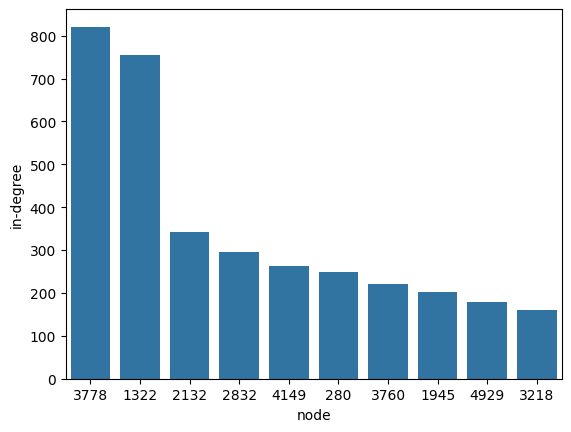

In [ ]:
k=10
by = 'in-degree'
sns.barplot(
  data=degree_data_df.sort_values(by=by, ascending=False).reset_index(drop=True).head(k),
  x='node',
  y=by,
  order=degree_data_df.sort_values(by=by, ascending=False).reset_index(drop=True).head(k)['node']
)

In [ ]:
degree_data_df.sort_values(by='out-degree', ascending=False).reset_index(drop=True).where(lambda x: x['node'] == 3973).dropna()

,node,in-degree,out-degree
2968,3973.0,1.0,3.0


<Axes: >

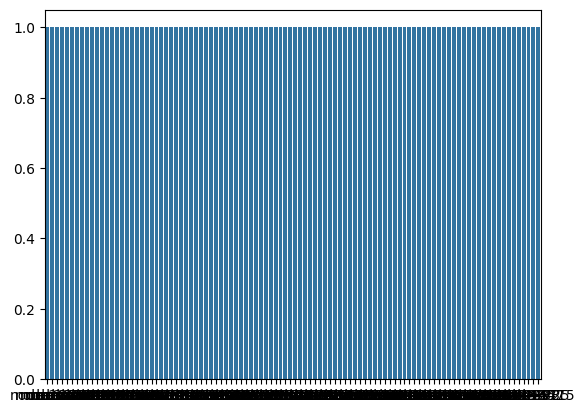

In [ ]:
sns.barplot(particular_states_df[particular_states_df['Drug'] == 'control'].drop(columns=['Drug']).mean().sort_values(ascending=False).head(100))

In [ ]:
sum(particular_states_df[particular_states_df['Drug'] == 'control'].drop(columns=['Drug']).mean().sort_values(ascending=False) == 0)

2087

In [ ]:
!ls

Icon?       code        paper       pics        pretty-data raw-data


In [ ]:
accuracies_out_degree_50_df = pd.read_csv('data/random-forests/out-degree-retention-vs-accuracy-v2-50.csv')
accuracies_in_degree_50_df = pd.read_csv('data/random-forests/in-degree-retention-vs-accuracy-v2-50.csv')
accuracies_max_in_degree_50_df = pd.read_csv('data/random-forests/max-in-degree-retention-vs-accuracy-v2-50.csv')
accuracies_orthogonal_max_in_degree_50_df = pd.read_csv('data/random-forests/orthogonal-max-in-degree-retention-vs-accuracy-v2-50.csv')
accuracies_more_overlap_orthogonal_max_in_degree_50_df = pd.read_csv('data/random-forests/more-overlap-orthogonal-max-in-degree-retention-vs-accuracy-v2-50.csv')
accuracies_min_out_degree_50_df = pd.read_csv('data/random-forests/min-out-degree-retention-vs-accuracy-v2-50.csv')
accuracies_random_50_df = pd.read_csv('data/random-forests/retention-vs-accuracy-v2.csv')
accuracies_orthogonal_50_df = pd.read_csv('data/random-forests/orthogonal-out-degree-retention-vs-accuracy-v2-50.csv')
accuracies_jaccard_50_df = pd.read_csv('data/random-forests/jaccard-retention-vs-accuracy-v2-50.csv')
accuracies_smart_50_df = pd.read_csv('data/random-forests/smart-retention-vs-accuracy-v2-50.csv')
accuracies_smarter_50_df = pd.read_csv('data/random-forests/smarter-retention-vs-accuracy-v2-50.csv')
accuracies_smartest_50_df = pd.read_csv('data/random-forests/smartest-retention-vs-accuracy-v2-50.csv')

accuracies_out_degree_50_df['Number of target nodes'] = 50
accuracies_in_degree_50_df['Number of target nodes'] = 50
accuracies_max_in_degree_50_df['Number of target nodes'] = 50
accuracies_orthogonal_max_in_degree_50_df['Number of target nodes'] = 50
accuracies_more_overlap_orthogonal_max_in_degree_50_df['Number of target nodes'] = 50
accuracies_min_out_degree_50_df['Number of target nodes'] = 50
accuracies_random_50_df['Number of target nodes'] = 50
accuracies_orthogonal_50_df['Number of target nodes'] = 50
accuracies_jaccard_50_df['Number of target nodes'] = 50
accuracies_smart_50_df['Number of target nodes'] = 50
accuracies_smarter_50_df['Number of target nodes'] = 50
accuracies_smartest_50_df['Number of target nodes'] = 50

accuracies_out_degree_50_df['strategy'] = 'max-out-degree'
accuracies_in_degree_50_df['strategy'] = 'min-in-degree'
accuracies_max_in_degree_50_df['strategy'] = 'max-in-degree'
accuracies_orthogonal_max_in_degree_50_df['strategy'] = 'ox-in-degree'
accuracies_more_overlap_orthogonal_max_in_degree_50_df['strategy'] = 'moox-in-degree'
accuracies_min_out_degree_50_df['strategy'] = 'min-out-degree'
accuracies_random_50_df['strategy'] = 'random'
accuracies_orthogonal_50_df['strategy'] = 'orthogonal'
accuracies_jaccard_50_df['strategy'] = 'jaccard'
accuracies_smart_50_df['strategy'] = 'smart'
accuracies_smarter_50_df['strategy'] = 'smarter'
accuracies_smartest_50_df['strategy'] = 'smartest'

accuracies_df = pd.concat([
  accuracies_random_50_df,
  accuracies_out_degree_50_df,
  accuracies_in_degree_50_df,
  accuracies_max_in_degree_50_df,
  # accuracies_orthogonal_max_in_degree_50_df,
  # accuracies_more_overlap_orthogonal_max_in_degree_50_df,
  # accuracies_orthogonal_50_df,
  accuracies_min_out_degree_50_df,
  # accuracies_jaccard_50_df,
  # accuracies_smart_50_df,
  # accuracies_smarter_50_df,
  # accuracies_smartest_50_df,
])

# [accuracies_50_df, accuracies_500_df, accuracies_25_df, accuracies_250_df])
accuracies_df.sample(10)

,num_features,accuracy,Number of target nodes,strategy
340,4,0.090909,50,min-in-degree
260,1,0.181818,50,max-in-degree
275,4,0.181818,50,random
579,128,0.909091,50,max-in-degree
533,1,0.090909,50,min-out-degree
628,16,0.454545,50,max-out-degree
548,4,0.181818,50,random
228,128,0.727273,50,min-in-degree
300,2,0.090909,50,min-in-degree
491,1024,1.000000,50,max-out-degree


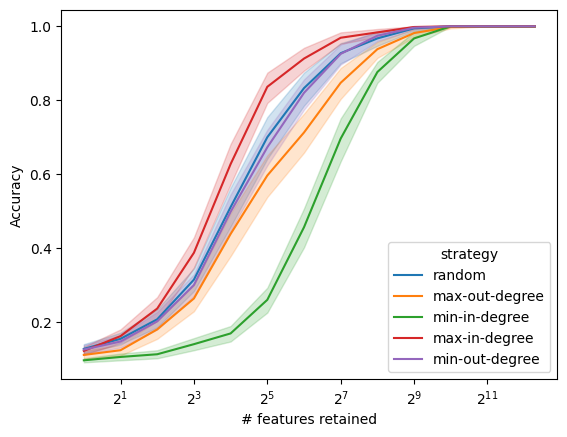

In [ ]:
g = sns.lineplot(data=accuracies_df, x='num_features', y='accuracy', hue='strategy', palette='tab10')
g.set(xlabel='# features retained', ylabel='Accuracy')#, xlim=(1, 30))
g.set_xscale('log', base=2)

In [ ]:
g.figure.savefig('plots/retention-vs-accuracy-random-nodes-multiple.svg', dpi=300, bbox_inches='tight')

In [ ]:
strategies = {
  'random': 'data/random-forests/retention-vs-accuracy-v2-50-reversed.csv',
  'max-overlap': 'data/random-forests/more-overlap-orthogonal-max-in-degree-retention-vs-accuracy-v2-50-reversed.csv',
  'max-in-degree': 'data/random-forests/max-in-degree-retention-vs-accuracy-v2-50-reversed.csv',
}

dfs = []
for strategy in strategies:
  dfs.append(pd.read_csv(strategies[strategy]))
  dfs[-1]['strategy'] = strategy
accuracies_reversed_df = pd.concat(dfs)
accuracies_reversed_df

,num_features,accuracy,strategy
0,1,0.090909,random
1,2,0.090909,random
2,4,0.181818,random
3,8,0.181818,random
4,16,0.272727,random
...,...,...,...
645,256,1.000000,max-in-degree
646,512,1.000000,max-in-degree
647,1024,1.000000,max-in-degree
648,2048,1.000000,max-in-degree


In [ ]:
g = sns.lineplot(data=accuracies_reversed_df, x='num_features', y='accuracy', hue='strategy', palette='tab10')
g.set(xlabel='# features retained', ylabel='Accuracy')#, xlim=(1, 30))
g.set_xscale('log', base=2)

NameError: name 'accuracies_reversed_df' is not defined

In [ ]:
strategies_normal = {
  'random': 'data/random-forests/retention-vs-accuracy-v2.csv',
  #'max-overlap': 'data/random-forests/more-overlap-orthogonal-max-in-degree-retention-vs-accuracy-v2-50.csv',
  'max-in-degree': 'data/random-forests/max-in-degree-retention-vs-accuracy-v2-50.csv',
  # 'activity': 'data/random-forests/dynamics-retention-vs-accuracy-v2-50.csv',
  'activity-enhanced': 'data/random-forests/dynamics-more-info-red-retention-vs-accuracy-v2-50-all-no-seed-256.csv',
  # 'dynamics-seed': 'data/random-forests/dynamics-more-info-in-seed-retention-vs-accuracy-v2-50.csv',
  'genetic': 'data/random-forests/retention-vs-accuracy-v1217d-N5k-10drugs-genetic-combined.csv',
  'genetic-enhanced': 'data/random-forests/retention-vs-accuracy-v0122d-N5k-10drugs-genetic-combined.csv',
}

dfs = []
for strategy in strategies_normal:
  dfs.append(pd.read_csv(strategies_normal[strategy]).rename(columns={'max_num_features': 'num_features'}))
  if 'features' in dfs[-1].columns:
    dfs[-1] = dfs[-1].drop(columns=['features', 'original_network_idx'])
  dfs[-1]['strategy'] = strategy
accuracies_df = pd.concat(dfs)
accuracies_df = accuracies_df[(accuracies_df['strategy'] != 'activity') | (accuracies_df['num_features'] <= 64)]
accuracies_df = accuracies_df[(accuracies_df['strategy'] != 'activity-enhanced') | (accuracies_df['num_features'] <= 256)]
# accuracies_df = accuracies_df[accuracies_df['num_features'] <= 256]
# accuracies_df[accuracies_df['strategy'] == 'activity']

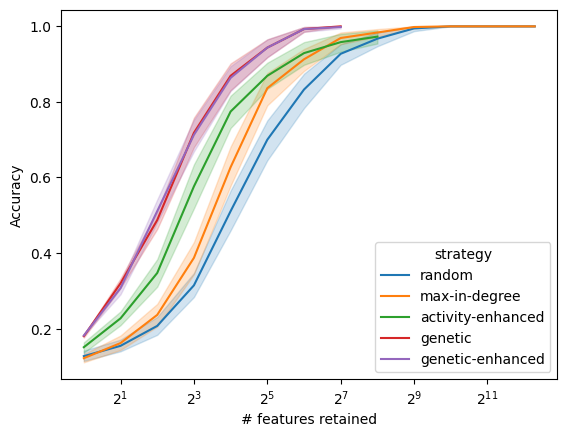

In [ ]:
g = sns.lineplot(data=accuracies_df, x='num_features', y='accuracy', hue='strategy', palette='tab10')
g.set(xlabel='# features retained', ylabel='Accuracy')#, xlim=(1, 30))
g.set_xscale('log', base=2)

In [ ]:
accuracies_df[(accuracies_df['strategy']=='activity-enhanced') & (accuracies_df['num_features'] == 128)]

,num_features,accuracy,strategy,original_network_idx,features
7,128,1.000000,activity-enhanced,0.0,"['node-2069', 'node-1050', 'node-192', 'node-4..."
16,128,1.000000,activity-enhanced,1.0,"['node-3804', 'node-49', 'node-37', 'node-1048..."
25,128,1.000000,activity-enhanced,2.0,"['node-1901', 'node-673', 'node-1324', 'node-2..."
34,128,1.000000,activity-enhanced,3.0,"['node-1882', 'node-0', 'node-53', 'node-26', ..."
43,128,0.818182,activity-enhanced,4.0,"['node-8', 'node-0', 'node-2', 'node-280', 'no..."
52,128,1.000000,activity-enhanced,5.0,"['node-2668', 'node-217', 'node-289', 'node-52..."
61,128,1.000000,activity-enhanced,6.0,"['node-579', 'node-220', 'node-281', 'node-549..."
70,128,0.909091,activity-enhanced,7.0,"['node-1698', 'node-224', 'node-114', 'node-33..."
79,128,0.909091,activity-enhanced,8.0,"['node-2054', 'node-73', 'node-145', 'node-290..."
88,128,0.818182,activity-enhanced,9.0,"['node-2282', 'node-4994', 'node-282', 'node-1..."


In [ ]:
ndf = pd.read_csv('data/random-forests/dynamics-more-info-retention-vs-accuracy-v2-50.csv', index_col=0).reset_index()
tdf = pd.read_csv('data/random-forests/dynamics-more-info-in-seed-retention-vs-accuracy-v2-50.csv', index_col=0).reset_index()

In [ ]:
strategies_N500 = {
  'random': 'data/random-forests/retention-vs-accuracy-v1211d.csv',
  'genetic': 'data/random-forests/retention-vs-accuracy-v1211d-genetic.csv',
}
dfs = []
for strategy in strategies_N500:
  dfs.append(pd.read_csv(strategies_N500[strategy]))
  dfs[-1]['strategy'] = strategy
accuracies_N500_df = pd.concat(dfs)

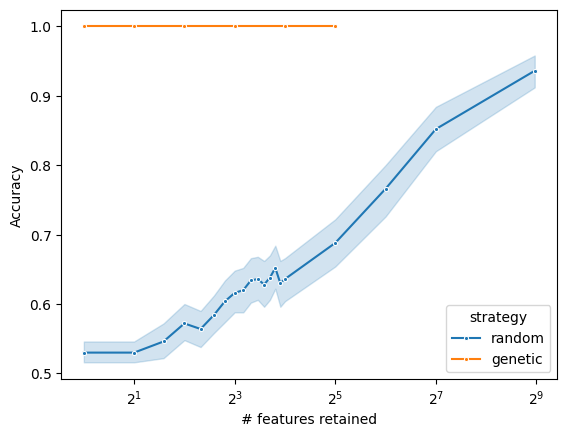

In [ ]:
g = sns.lineplot(data=accuracies_N500_df, x='num_features', y='accuracy', hue='strategy', palette='tab10', marker='.')
g.set(xlabel='# features retained', ylabel='Accuracy')#, xlim=(1, 30))
g.set_xscale('log', base=2)

In [ ]:
accuracies_N500_df[accuracies_N500_df['strategy'] == 'genetic']

,num_features,accuracy,strategy,original_network_idx,features
0,1,1.0,genetic,0.0,{'node-430'}
1,2,1.0,genetic,0.0,"{'node-70', 'node-11'}"
2,4,1.0,genetic,0.0,"{'node-486', 'node-279', 'node-114', 'node-391'}"
3,8,1.0,genetic,0.0,"{'node-416', 'node-13', 'node-350', 'node-128'..."
4,16,1.0,genetic,0.0,"{'node-65', 'node-87', 'node-414', 'node-299',..."
5,32,1.0,genetic,0.0,"{'node-379', 'node-403', 'node-142', 'node-130..."


In [ ]:
strategies_N500_2drugs = {
  'random': 'data/random-forests/retention-vs-accuracy-v1211d-2drugs.csv',
  'max-in-degree': 'data/random-forests/max-in-degree-retention-vs-accuracy-v1217d-50.csv',
  # 'genetic': 'data/random-forests/retention-vs-accuracy-v1211d-2drugs-genetic.csv',
  'activity': 'data/random-forests/dynamics-retention-vs-accuracy-v1217d-50.csv',
  'genetic': 'data/random-forests/retention-vs-accuracy-v1217d-2drugs-genetic-combined.csv'
}
dfs = []
for strategy in strategies_N500_2drugs:
  dfs.append(pd.read_csv(strategies_N500_2drugs[strategy], index_col=None).rename(columns={'max_num_features': 'num_features'}))
  if 'features' in dfs[-1].columns:
    dfs[-1] = dfs[-1].drop(columns=['features', 'original_network_idx'])
  dfs[-1]['strategy'] = strategy

accuracies_N500_2drugs_df = pd.concat(dfs)

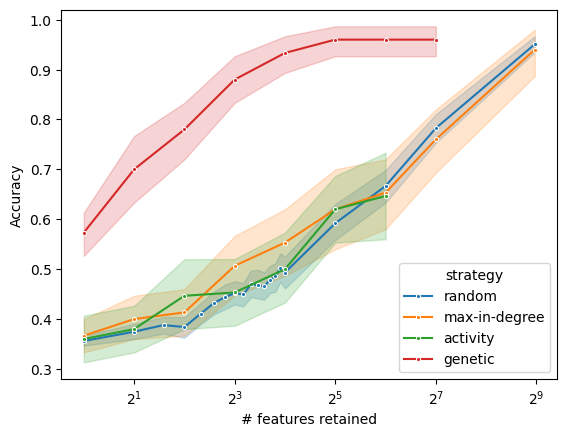

In [ ]:
g = sns.lineplot(data=accuracies_N500_2drugs_df, x='num_features', y='accuracy', hue='strategy', palette='tab10', marker='.')
g.set(xlabel='# features retained', ylabel='Accuracy')#, xlim=(1, 30))
g.set_xscale('log', base=2)

In [ ]:
pure_feature_order = eval(ndf[ndf.original_network_idx == 0].features.iloc[4])
first_in_feature_order = eval(tdf[tdf.original_network_idx == 0].features.iloc[4])

In [ ]:
networks_df

,original_network_idx,source,target,weight
0,0,721,0,-0.250532
1,0,1484,0,-0.808049
2,0,2290,0,0.002714
3,0,2832,0,-0.317106
4,0,3760,0,0.628091
...,...,...,...,...
1416284,49,2561,4999,-0.709303
1416285,49,3089,4999,-0.699658
1416286,49,3402,4999,-0.241315
1416287,49,3724,4999,-0.684129


In [ ]:
feature_df = pd.read_csv('data/random-forests/retention-vs-accuracy-v1217d-N5k-10drugs-genetic-combined.csv', index_col=0).reset_index()
feature_df.sample(n=10)

,original_network_idx,max_num_features,accuracy,features
47,5,128,1.000000,"{'node-521', 'node-1087', 'node-274', 'node-36..."
48,6,1,0.181818,{'node-2238'}
112,14,1,0.181818,{'node-4875'}
208,26,1,0.181818,{'node-4069'}
395,49,8,0.727273,"{'node-428', 'node-3271', 'node-1510', 'node-3..."
367,45,128,1.000000,"{'node-4681', 'node-3551', 'node-4474', 'node-..."
266,33,4,0.454545,"{'node-4742', 'node-1738', 'node-3990', 'node-..."
314,39,4,0.454545,"{'node-3857', 'node-3687', 'node-3343', 'node-..."
59,7,8,0.636364,"{'node-4145', 'node-4915', 'node-1403', 'node-..."
294,36,64,1.000000,"{'node-1391', 'node-874', 'node-1451', 'node-2..."


In [ ]:
Gs = [nx.DiGraph() for _ in range(len(networks_df['original_network_idx'].unique()))]
for (idx,), rows in networks_df.groupby(['original_network_idx']):
  for _, row in rows.iterrows():
    Gs[idx].add_edge(f'node-{int(row["source"])}', f'node-{int(row["target"])}', weight=abs(row['weight']), raw_weight=row['weight'])

Gs

In [ ]:
for (original_network_idx, raw_features), row in feature_df.groupby(['original_network_idx', 'features']):
  print(original_network_idx, eval(raw_features), type())
  break

0 {'node-1948', 'node-1452', 'node-4730', 'node-4875', 'node-4379', 'node-4518', 'node-2749', 'node-3795', 'node-244', 'node-2073', 'node-3593', 'node-3450', 'node-2929', 'node-339', 'node-1087', 'node-3995', 'node-1499', 'node-1900', 'node-982', 'node-769', 'node-2685', 'node-742', 'node-325', 'node-658', 'node-3431', 'node-1566', 'node-390', 'node-1576', 'node-2549', 'node-4909', 'node-3690', 'node-3231', 'node-1807', 'node-3174', 'node-812', 'node-2181', 'node-1910', 'node-1412', 'node-4664', 'node-3129', 'node-3624', 'node-2298', 'node-1035', 'node-1345', 'node-1386', 'node-990', 'node-821', 'node-1764', 'node-2999', 'node-3703', 'node-3859', 'node-4122', 'node-3609', 'node-2268', 'node-4530', 'node-1516', 'node-3907', 'node-585', 'node-4148'} <class 'numpy.int64'>


In [ ]:
Gs[0].in_degree('node-1948')
data = []
for (original_network_idx, raw_features), row in feature_df.groupby(['original_network_idx', 'features']):
  G = Gs[original_network_idx]
  features = eval(raw_features)
  for feature_idx, feature in enumerate(features):
    data.append({
        'original_network_idx': original_network_idx,
        'num_features': row.max_num_features.squeeze(),
        'feature': feature,
        'in-degree': G.in_degree(feature),
        'out-degree': G.out_degree(feature),
        'accuracy': row['accuracy'].squeeze(),
    })

stats_df = pd.DataFrame(data)
stats_df



,original_network_idx,num_features,feature,in-degree,out-degree,accuracy
0,0,64,node-1948,4,2,1.000000
1,0,64,node-1452,3,1,1.000000
2,0,64,node-4730,2,1,1.000000
3,0,64,node-4875,3,1,1.000000
4,0,64,node-4379,4,2,1.000000
...,...,...,...,...,...,...
12157,49,8,node-510,4,4,0.727273
12158,49,8,node-3640,3,1,0.727273
12159,49,2,node-4575,2,1,0.272727
12160,49,2,node-3962,9,1,0.272727


<Axes: xlabel='num_features', ylabel='in-degree'>

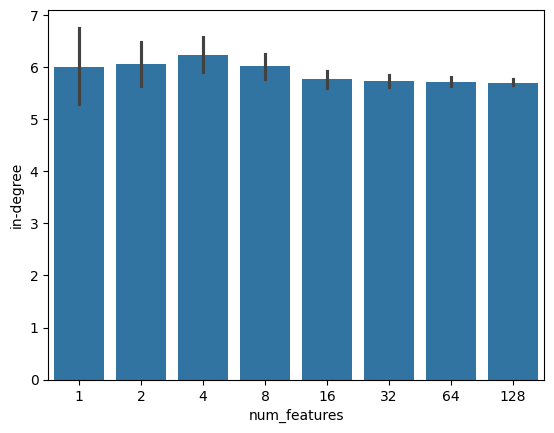

In [ ]:
sns.barplot(stats_df, x='num_features', y='in-degree')

<Axes: xlabel='num_features', ylabel='out-degree'>

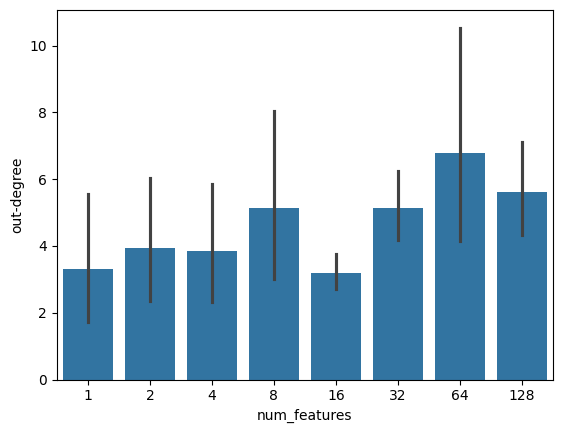

In [ ]:
sns.barplot(stats_df, x='num_features', y='out-degree')

In [ ]:
data = []
res = sorted(
  [
    ((original_network_idx, eval(raw_features)), row)
    for ((original_network_idx, raw_features), row) in feature_df.groupby(['original_network_idx', 'features'])
  ],
  key=lambda x: (x[0][0], len(x[0][1])),
)
for (original_network_idx, features), row in res:
  G = Gs[original_network_idx]
  # print(original_network_idx, len(features))
  successors = set()
  predecessors = set()
  for feature_idx, feature in enumerate(features):
    successors.update(G.successors(feature))
    predecessors.update(G.predecessors(feature))

  data.append({
    'original_network_idx': original_network_idx,
    'num_features': row.max_num_features.squeeze(),
    'feature': feature,
    'cum-num-predecessors': len(predecessors),
    'cum-num-successors': len(successors),
    'accuracy': row['accuracy'].squeeze(),
  })

reg_stats_df = pd.DataFrame(data)
reg_stats_df

,original_network_idx,num_features,feature,cum-num-predecessors,cum-num-successors,accuracy
0,0,1,node-821,5,2,0.181818
1,0,2,node-4169,12,22,0.363636
2,0,4,node-857,19,5,0.454545
3,0,8,node-3633,33,21,0.818182
4,0,16,node-4154,55,55,1.000000
...,...,...,...,...,...,...
395,49,8,node-3640,34,16,0.727273
396,49,16,node-2169,78,24,1.000000
397,49,32,node-4402,135,108,1.000000
398,49,64,node-181,202,130,1.000000


(1, 5000)

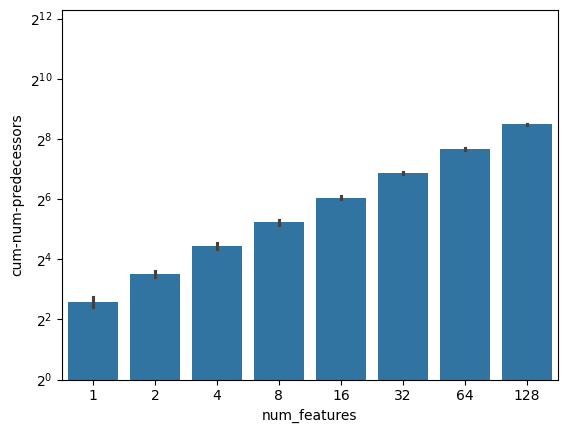

In [ ]:
g = sns.barplot(reg_stats_df, x='num_features', y='cum-num-predecessors')
g.set_yscale('log', base=2)
g.set_ylim(1, 5000)

In [ ]:
from sklearn.linear_model import LinearRegression

In [ ]:
f = reg_stats_df.groupby('num_features')['cum-num-predecessors'].mean().to_dict()
x, y = zip(*sorted(f.items()))
x = np.array(x).reshape(-1, 1)
reg = LinearRegression().fit(x, y)
reg

LinearRegression()

In [ ]:
y

(6.0, 11.5, 21.68, 37.5, 66.2, 116.9, 202.68, 359.86)

In [ ]:
reg.coef_, reg.intercept_, reg.score(x, y)

(array([2.77307113]), np.float64(14.398357862122353), 0.9937539735616648)

(-1.0, 4.5)

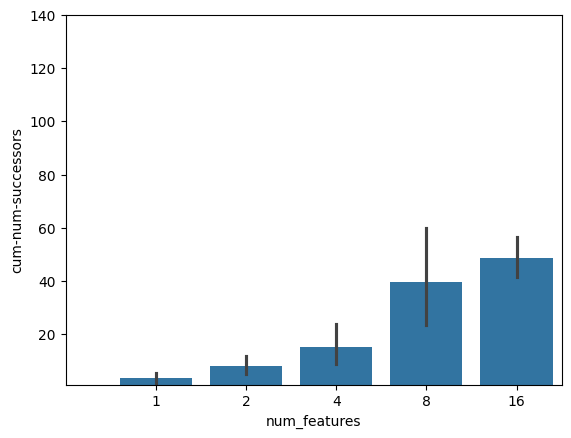

In [ ]:
g = sns.barplot(reg_stats_df, x='num_features', y='cum-num-successors')
# g.set_yscale('log', base=2)
g.set_ylim(1, 140)
g.set_xlim(-1, 4.5)

In [ ]:
f = reg_stats_df.groupby('num_features')['cum-num-successors'].mean().to_dict()
x, y = zip(*sorted(f.items()))
x = np.array(x).reshape(-1, 1)
reg = LinearRegression().fit(x, y)
reg.coef_, reg.intercept_, reg.score(x, y)

(array([5.18582421]), np.float64(-2.7556467854376763), 0.9821442590156917)

In [ ]:
import random
import operator
from functools import reduce
k = 16
similars = []
for G in Gs:
  nodes = list(G.nodes())
  for _ in range(10000):
    us = random.choices(nodes, k=k)#, replace=False)
    pred_us = [set(G.predecessors(u)) for u in us]
    similar = len(reduce(operator.__or__, pred_us, set()))
    similars.append(similar)

df = pd.DataFrame(similars, columns=['similar'])
df

,similar
0,42
1,55
2,57
3,57
4,55
...,...
499995,67
499996,66
499997,58
499998,59


<Axes: xlabel='similar', ylabel='Probability'>

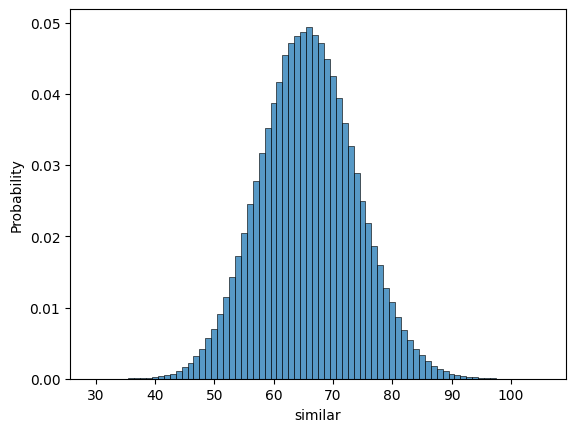

In [ ]:
sns.histplot(df['similar'], discrete=True, stat='probability')

In [ ]:
df['similar'].describe()

count    500000.00000
mean         65.82753
std           8.11028
min          30.00000
25%          60.00000
50%          66.00000
75%          71.00000
max         105.00000
Name: similar, dtype: float64

In [ ]:
y

(6.0, 11.5, 21.68, 37.5, 66.2, 116.9, 202.68, 359.86)

In [ ]:
palette = sns.color_palette("tab20", 20)
palette

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (0.6823529411764706, 0.7803921568627451, 0.9098039215686274),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (1.0, 0.7333333333333333, 0.47058823529411764),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.596078431372549, 0.8745098039215686, 0.5411764705882353),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (1.0, 0.596078431372549, 0.5882352941176471),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.7725490196078432, 0.6901960784313725, 0.8352941176470589),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.7686274509803922, 0.611764705882353, 0.5803921568627451),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 (0.9686274509803922, 0.7137254901960784, 0.8235294117647058),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 (0.7803921568627451, 0.7803921568627451, 0.7803921568627451),
 (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
 (0.8588235294117647, 0.8588235294117647, 0.5529411764705883),
 (0.09019607843137255, 0.7450980392156863, 0.8117647058823529),
 (0.6196078431372549, 0.8549019607843137, 0.8980392156862745)]

(np.float64(0.0), np.float64(1.0), np.float64(0.0), np.float64(1.0))

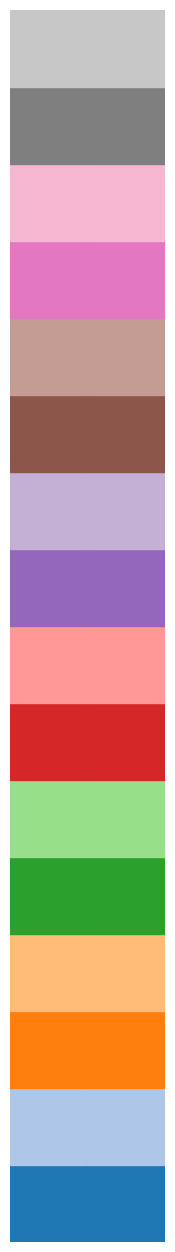

In [ ]:
from matplotlib import patches
k = 16
fig, ax = plt.subplots(1, 1, figsize=.np.array([2, k]))
for i, e in enumerate(pure_feature_order):
  ax.add_patch(patches.Rectangle((0, i/k), 1/2, 1/k, color=palette[i]))
for i, e in enumerate(first_in_feature_order):
  ax.add_patch(patches.Rectangle((1/2, i/k), 1/2, 1/k, color=palette[i]))

ax.axis('off')


In [ ]:
particular_network_df = networks_df[networks_df['original_network_idx'] == 0]
G = nx.DiGraph()
for _, row in particular_network_df.iterrows():
  G.add_edge(f'node-{int(row["source"])}', f'node-{int(row["target"])}', weight=abs(row['weight']), raw_weight=row['weight'])

In [ ]:
nx.draw(G, pos=pos, node_size=5)

In [ ]:
nx.write_gexf(G, 'plots/network.gexf')

In [ ]:
import json
with open('data/network.json', 'w') as f:
  json.dump(nx.cytoscape_data(G), f)

In [ ]:
list(G.nodes())[0]

np.float64(721.0)

In [ ]:
ndf

,num_features,accuracy,features
original_network_idx,,,
0,1,0.181818,['node-12']
0,2,0.272727,"['node-12', 'node-332']"
0,4,0.545455,"['node-12', 'node-332', 'node-22', 'node-6']"
0,8,0.545455,"['node-12', 'node-332', 'node-22', 'node-6', '..."
0,16,0.818182,"['node-12', 'node-332', 'node-22', 'node-6', '..."
...,...,...,...
49,256,1.000000,"['node-1', 'node-32', 'node-107', 'node-842', ..."
49,512,1.000000,"['node-1', 'node-32', 'node-107', 'node-842', ..."
49,1024,1.000000,"['node-1', 'node-32', 'node-107', 'node-842', ..."


In [ ]:
original_network_idx = 0
particular_ndf = ndf[ndf['original_network_idx'] == original_network_idx]
particular_network_df = networks_df[networks_df['original_network_idx'] == original_network_idx]

features = eval(particular_ndf[particular_ndf['num_features'] == 64]['features'].iloc[0])
features

['node-12',
 'node-332',
 'node-22',
 'node-6',
 'node-63',
 'node-60',
 'node-588',
 'node-1598',
 'node-732',
 'node-1511',
 'node-1791',
 'node-139',
 'node-657',
 'node-350',
 'node-1909',
 'node-185',
 'node-2413',
 'node-3663',
 'node-51',
 'node-59',
 'node-2965',
 'node-1578',
 'node-3328',
 'node-2224',
 'node-3414',
 'node-1362',
 'node-2266',
 'node-1481',
 'node-4422',
 'node-4347',
 'node-668',
 'node-371',
 'node-4272',
 'node-2958',
 'node-2817',
 'node-3608',
 'node-2279',
 'node-313',
 'node-4847',
 'node-1562',
 'node-3727',
 'node-2661',
 'node-480',
 'node-2555',
 'node-180',
 'node-1024',
 'node-543',
 'node-1987',
 'node-1398',
 'node-3583',
 'node-1386',
 'node-1569',
 'node-827',
 'node-3754',
 'node-1766',
 'node-4813',
 'node-283',
 'node-1083',
 'node-539',
 'node-1756',
 'node-3157',
 'node-2835',
 'node-1296',
 'node-4746']

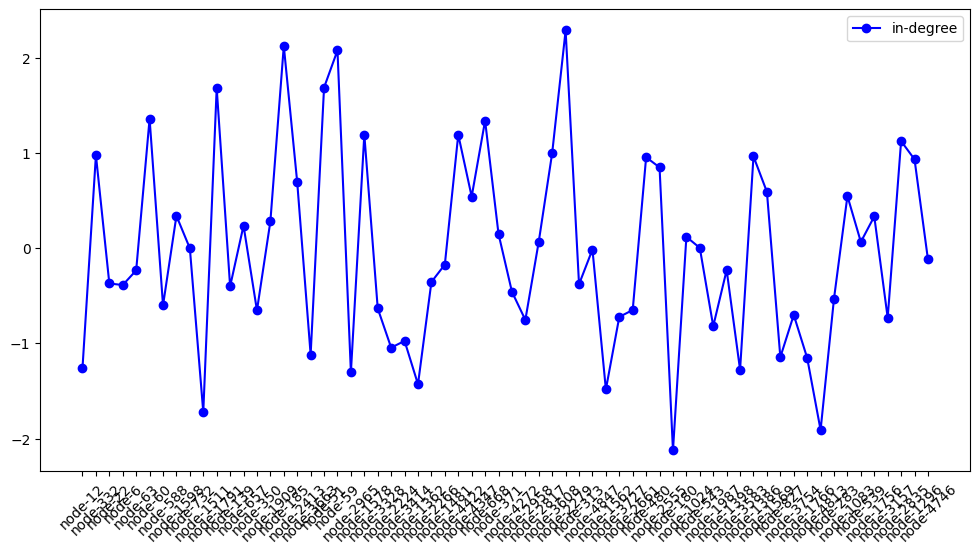

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
in_degrees = [G.in_degree(feature, weight='raw_weight') for feature in features]
# out_degrees = [G.out_degree(feature, weight='weight') for feature in features]
# cs = nx.closeness_centrality(G, distance="weight")
xs = [cs[feature] for feature in features]
plt.plot(features, in_degrees, label='in-degree', color='blue', marker='o')
# plt.plot(features, out_degrees, label='out-degree', color='orange', marker='o')
#plt.plot(xs, marker='o')
# plt.hlines([max(v for k, v in G.in_degree())], 0, len(features),  linestyles='dashed', colors=['blue'])
# plt.hlines([np.mean([v for k, v in G.in_degree(weight='weight')])], 0, len(features),  linestyles='dashed', colors=['blue'])
# plt.hlines([max(v for k, v in G.out_degree())], 0, len(features),  linestyles='dashed', colors=['orange'])
# plt.hlines([np.mean([v for k, v in G.out_degree()])], 0, len(features),  linestyles='dashed', colors=['orange'])
# plt.yscale('log')
ax.tick_params(axis='x', labelrotation=45)
plt.legend()

In [ ]:
data = []
for u in G.nodes():
  data.append((u, G.in_degree(u), G.out_degree(u), u in features))
ddf = pd.DataFrame(data, columns=['node', 'in-degree', 'out-degree', 'featured?'])
ddf = ddf.sort_values(by='featured?', ascending=True)

[None]

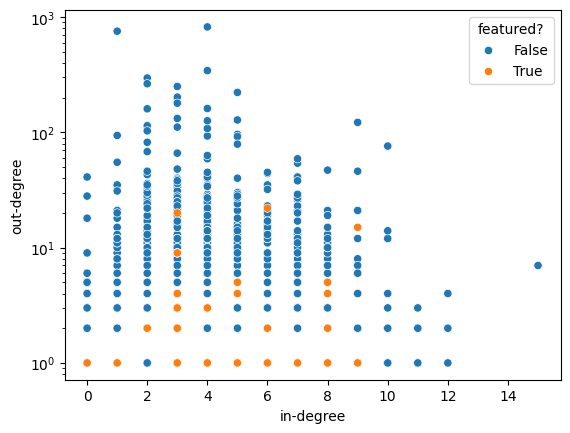

In [ ]:
sns.scatterplot(ddf, x='in-degree', y='out-degree', hue='featured?').set(yscale='log')

In [ ]:
np.mean([v for k, v in G.in_degree()])

np.float64(3.8818)

In [ ]:
data = []
for original_network_idx in range(50):
  particular_ndf = ndf[ndf['original_network_idx'] == original_network_idx]

  particular_network_df = networks_df[networks_df['original_network_idx'] == original_network_idx]
  G = nx.DiGraph()
  for _, row in particular_network_df.iterrows():
    G.add_edge(f'node-{int(row["source"])}', f'node-{int(row["target"])}', weight=abs(row['weight']), raw_weight=row['weight'])

  features = eval(particular_ndf[particular_ndf['num_features'] == 64]['features'].iloc[0])
  for feature_idx, feature in enumerate(features):
    data.append((original_network_idx, feature_idx, feature, G.in_degree(feature), G.out_degree(feature)))

phi_df = pd.DataFrame(data, columns=['original_network_idx', 'feature_idx', 'feature', 'in-degree', 'out-degree'])
phi_df

,original_network_idx,feature_idx,feature,in-degree,out-degree
0,0,0,node-12,3,1
1,0,1,node-332,5,1
2,0,2,node-22,7,1
3,0,3,node-6,8,1
4,0,4,node-63,5,1
...,...,...,...,...,...
3195,49,59,node-12,4,5
3196,49,60,node-13,5,1
3197,49,61,node-14,10,1
3198,49,62,node-15,3,5


/var/folders/nr/wh_xmblj0d57jnlt98fssqqh0000gp/T/ipykernel_43059/4057361365.py:1: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(


<Axes: xlabel='feature_idx', ylabel='in-degree'>

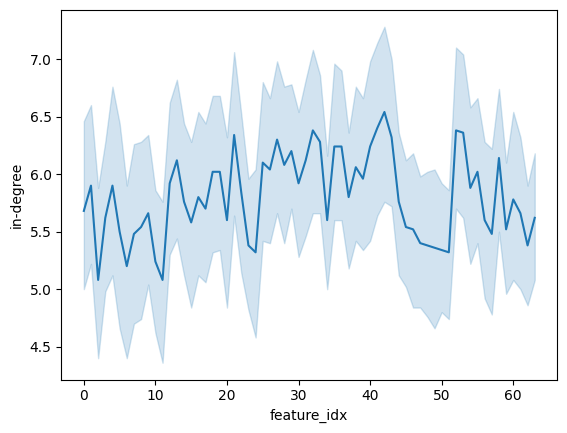

In [ ]:
sns.lineplot(
  phi_df,
  x='feature_idx',
  y='in-degree',
  #hue='original_network_idx',
  palette='tab10',
)

# plt.hlines([np.mean([v for k, v in G.in_degree()])], 0, len(features),  linestyles='dashed', colors=['black'])

In [ ]:
data = []
for original_network_idx in range(50):
  particular_ndf = ndf[ndf['original_network_idx'] == original_network_idx]

  particular_network_df = networks_df[networks_df['original_network_idx'] == original_network_idx]
  G = nx.DiGraph()
  for _, row in particular_network_df.iterrows():
    G.add_edge(f'node-{int(row["source"])}', f'node-{int(row["target"])}', weight=abs(row['weight']), raw_weight=row['weight'])

  data.extend(v for k, v in G.in_degree())
np.mean(data)

np.float64(5.665156)